# Relating quantities measured in the FBZ to systemwide quantites

We measure $N_0 \equiv N_{\mathbf{k} = \mathbf{0}}$ and $N_{\mathrm{FBZ}}$ and want to relate these quantities to $N_{\mathrm{BEC}}$ and $N_{\mathrm{tot}}$ using the Wannier functions $w_{n, j}(\mathbf{x}) = \sqrt{\frac{d}{2\pi}} \int_{\mathrm{FBZ}} \mathrm{d}\mathbf{q} \psi_{n, \mathbf{q}}(x) e^{-ij\mathbf{q}d}$ where $j \in \mathbb{Z}$ corresponds to the index of the lattice site and $n = 0$ (omitted hereafter) to the index of the lowest lattice band in the tight-binding limit. The Fourier-transformed Wannier functions are denoted $\tilde{w}(\mathbf{k})$. In a 3D cubic lattice they factorize, so the atom number in momentum space is related to:

$N(\mathbf{k}) \sim |\tilde{w}(\mathbf{k})|^2 = |\tilde{w}(k_x)|^2 \times |\tilde{w}(k_y)|^2 \times |\tilde{w}(k_z)|^2$

For the zero-momentum mode of the lowest energy state in the trap this implies simply:

$ \displaystyle  N_0 \sim |\tilde{w}(0)|^6$

The other condensed atoms $N_{\mathrm{BEC}} - N_0$ are dispersed over the diffraction peaks of order > 1:

$ \displaystyle N_{\mathrm{BEC}} \sim \sideset{}{'}\sum_{\mathbf{k}}|\tilde{w}(\mathbf{k})|^2$

where the sum runs over all diffraction peaks including the 0th order. Example: 2nd-order diffraction peak at $\mathbf{k}/k_d = (1, -1, 0)$: $|\tilde{w}(\mathbf{k})|^2 = |\tilde{w}(k_d)|^2 \times |\tilde{w}(-k_d)|^2 \times |\tilde{w}(0)|^2 = |\tilde{w}(k_d)|^4$ with the normalization of the Wannier functions to 1 at the origin. To calculate $N_{\mathrm{BEC}}$ for a specific diffraction order $n \in \mathbb{Z}$, let the sum run over all Miller indices $\mathbf{k}/k_d = (h, k, l)$ such that $|h| + |k| + |l| = n$.

The atom number of the first Brillouin zone (FBZ) is given by:

$ \displaystyle N_{\mathrm{FBZ}} \sim \left( \int_{-k_d/2}^{k_d/2}\mathrm{d}k|\tilde{w}(k)|^2 \right)^3$

and the corresponding total atom number by:

$ \displaystyle N_{\mathrm{tot}} \sim \left( \int_{-\infty}^{\infty}\mathrm{d}k|\tilde{w}(k)|^2 \right)^3$

In [1]:
"""SETUP"""

# Standard library imports:
import os
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# Local imports:
import lattice
from LatticeConf import *

# Plot setup:
if os.uname().sysname == 'Darwin':
    %matplotlib inline

In [2]:
""" Calculate Wannier functions and their Fourier transform"""

wannier_functions = pd.Series(index=sarr, dtype=object)
xsample = np.linspace(-50, 50, 500)
for s in sarr:
    _, bs = lattice.eigenproblem(s, qarr, bands=n, kohns_phase=True)
    wannier_functions[s] = np.real(lattice.wannier(xsample, bs))

# Calculate FT:
xsample = np.linspace(-50, 50, 500)
T = 2 * max(xsample) / len(xsample)  # Sampling distance in position space
karr = fftfreq(len(xsample), T)[:len(xsample)//2]  # Momentum space array for FT calculation
karr = np.concatenate((-karr[::-1], karr[1:]))  # Symmetrize

FTwannier_functions = pd.Series(index=sarr, dtype=object)
for s in sarr:
    # FFT:
    FTwannier_functions[s] = fft(wannier_functions.loc[s])
    # Normalize center to 1:
    FTwannier_functions[s] = FTwannier_functions.loc[s] / np.max(FTwannier_functions.loc[s])
    # Symmetrize:
    FTwannier_functions[s] = FTwannier_functions.loc[s][:len(FTwannier_functions.loc[s])//2]
    FTwannier_functions[s] = np.concatenate((FTwannier_functions.loc[s][::-1], FTwannier_functions.loc[s][1:]))

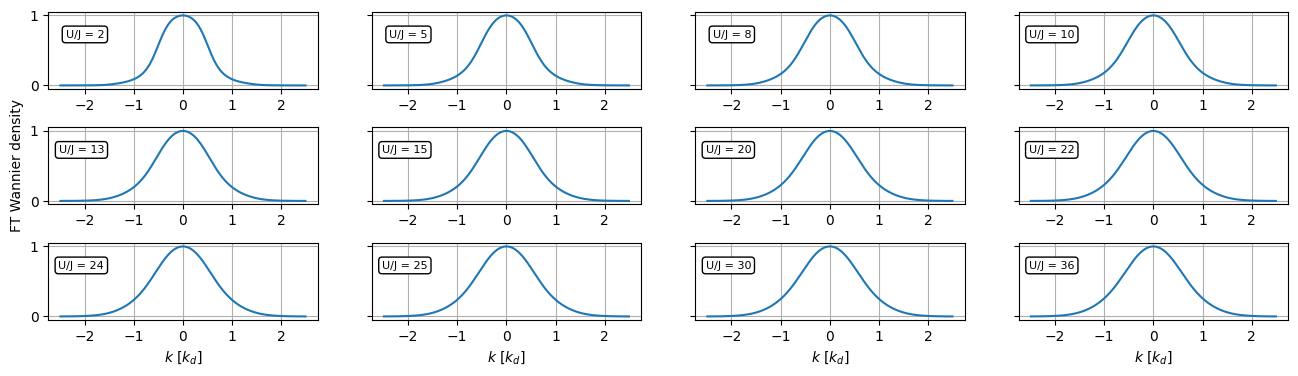

In [3]:
""" Plot mod. square of Wannier FT"""

# Get idxs for values of lattice amplitude corresponding to exp. datasets:
def find_closest(arr, search_val):
    """Helper function that returns the value in arr closest to search_val."""
    return arr[(np.abs(arr - search_val)).argmin()]
s_exps = np.array([find_closest(sarr, s_exp) for s_exp in uj_exp.values])

fig, axs = plt.subplots(3, 4, figsize=(16, 4), sharey=True)
for s_exp, ax in zip(s_exps, axs.flatten()):
    ax.plot(
        karr,
        np.abs(FTwannier_functions.loc[s_exp])**2
        )
    if s_exp > 12.6: ax.set_xlabel('$k$ [$k_d$]')
    ax.annotate(f"U/J = {np.round(uj['U/J'].loc[s_exp]):.0f}", xy=(-1.6, .8), size=8,
                ha='right', va='top',bbox=dict(boxstyle='round', fc='w'))
    ax.grid()
axs.flatten()[4].set_ylabel("FT Wannier density")
plt.subplots_adjust(hspace=.5)
plt.show()

In [4]:
# Calculate quantities proportional to atom numbers:

# Get momentum space sampling frequency for integration:
dk = karr[1] - karr[0]

# Determine indices of diffraction peaks:
k_0_idx = np.where(karr==0)[0][0]
k_bec_idxs = np.where([i.is_integer() for i in karr])[0]

# Set half-width of diffraction peaks:
peak_size = 0.1  # *2 [k_d]

# Determine FBZ indices:
fbz_idxs = [i for i in range(len(karr)) if -0.5 <= karr[i] <= 0.5]

# Prepare data container:
at_nb = pd.DataFrame(index=sarr, columns=['N_0', 'N_BEC', 'N_FBZ', 'N_TOT'], dtype=float)

# Set highest order of diffraction to include:    
n_max = int(max(karr))

# Calculate all combinations of diffraction peaks:
miller_indices = pd.MultiIndex.from_product([
    [-n_max + l for l in range(2 * n_max + 1)],
    [-n_max + l for l in range(2 * n_max + 1)],
    [-n_max + l for l in range(2 * n_max + 1)]
    ]).to_numpy()

# Filter to max. order:
miller_indices = miller_indices[np.where([abs(h) + abs(k) + abs(l) <= n_max for (h, k, l) in miller_indices])]

idx_map = {k: v for k, v in zip([-n_max + i for i in range(2 * n_max + 1)], k_bec_idxs)}

# Integrate FT Wannier functions:
for s in sarr:

    # N_0:
    ctr_peak_idxs = [i for i in range(len(karr)) if -peak_size <= karr[i] <= peak_size]
    at_nb['N_0'].at[s] = (sum(
        dk * (
            abs(FTwannier_functions.loc[s][ctr_peak_idxs])**2
            )
        ))**3
    
    # N_BEC:
    at_nb['N_BEC'].at[s] = 0
    
    for (h, k, l) in miller_indices:

        h_idx = idx_map[h]
        k_idx = idx_map[k]
        l_idx = idx_map[l]

        peak_idxs_h = [i for i in range(len(karr)) if -peak_size + h <= karr[i] <= peak_size + h]
        peak_idxs_k = [i for i in range(len(karr)) if -peak_size + k <= karr[i] <= peak_size + k]
        peak_idxs_l = [i for i in range(len(karr)) if -peak_size + l <= karr[i] <= peak_size + l]
        
        at_nb['N_BEC'].at[s] += (
            sum(dk*(abs(FTwannier_functions.loc[s][peak_idxs_h])**2))
            *sum(dk*(abs(FTwannier_functions.loc[s][peak_idxs_k])**2))
            *sum(dk*(abs(FTwannier_functions.loc[s][peak_idxs_l])**2))
        )
                
    at_nb['N_FBZ'].at[s] = (sum(dk*abs(FTwannier_functions.loc[s][fbz_idxs])**2))**3
    at_nb['N_TOT'].at[s] = (sum(dk*abs(FTwannier_functions.loc[s][:])**2))**3

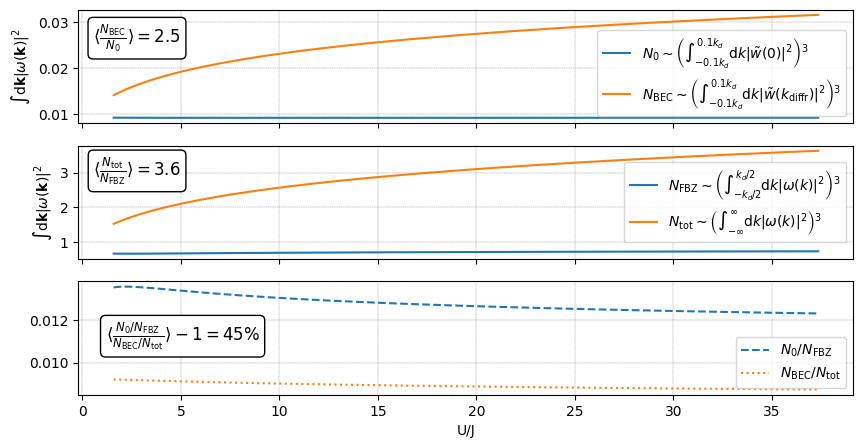

In [5]:
# Plot results as a function of U/J:

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
axs[0].plot(
    uj['U/J'],
    at_nb['N_0'],
    label=r'$N_0 \sim \left( \int_{-%sk_d}^{%sk_d}\mathrm{d}k |\tilde{w}(0)|^2 \right)^3$' % (peak_size, peak_size)
    )
axs[0].plot(
    uj['U/J'],
    at_nb['N_BEC'],
    label=r'$N_{\mathrm{BEC}} \sim \left(\int_{-%sk_d}^{%sk_d}\mathrm{d}k |\tilde{w}(k_{\mathrm{diffr}})|^2\right)^3$' % (peak_size, peak_size)
    )
axs[1].plot(
    uj['U/J'],
    at_nb['N_FBZ'],
    label=r'$N_{\mathrm{FBZ}} \sim \left( \int_{-k_d/2}^{k_d/2}\mathrm{d}k |\omega (k)|^2 \right)^3$'
    )
axs[1].plot(
    uj['U/J'],
    at_nb['N_TOT'],
    label=r'$N_{\mathrm{tot}} \sim \left( \int_{-\infty}^{\infty}\mathrm{d}k |\omega (k)|^2 \right)^3$'
    )
axs[2].plot(
    uj['U/J'],
    at_nb['N_0'] / at_nb['N_FBZ'],
    linestyle='--',
    label=r'$N_0 / N_{\mathrm{FBZ}}$'
    )
axs[2].plot(
    uj['U/J'],
    at_nb['N_BEC'] / at_nb['N_TOT'],
    linestyle=':',
    label=r'$N_{\mathrm{BEC}} / N_{\mathrm{tot}}$'
    )
for idx, ax in enumerate(axs):
    if idx==len(axs)-1:
        ax.set_xlabel('U/J')
        ax.annotate(r'$\langle \frac{N_0/N_{\mathrm{FBZ}}}{N_{\mathrm{BEC}}/N_{\mathrm{tot}}} \rangle - 1 = %s$' % int(100 * np.round(((at_nb['N_0'] / at_nb['N_FBZ'])/(at_nb['N_BEC'] / at_nb['N_TOT'])).mean() - 1, 2))+'%',
        xy=(9, 0.012), size=12, ha='right', va='top',bbox=dict(boxstyle='round', fc='w'))
    elif idx==len(axs)-2:
        ax.set_ylabel(r'$\int\mathrm{d}\mathbf{k} |\omega (\mathbf{k})|^2$')
        ax.annotate(r'$\langle \frac{N_{\mathrm{tot}}}{N_{\mathrm{FBZ}}} \rangle = %s$' % np.round((at_nb['N_TOT'] / at_nb['N_FBZ']).mean(), 1),
        xy=(5, 3.5), size=12, ha='right', va='top',bbox=dict(boxstyle='round', fc='w'))
    elif idx==len(axs)-3:
        ax.set_ylabel(r'$\int\mathrm{d}\mathbf{k} |\omega (\mathbf{k})|^2$')
        ax.annotate(r'$\langle \frac{N_{\mathrm{BEC}}}{N_0} \rangle = %s$' % np.round((at_nb['N_BEC'] / at_nb['N_0']).mean(), 1),
        xy=(5, 0.03), size=12, ha='right', va='top',bbox=dict(boxstyle='round', fc='w'))
    ax.legend()
    ax.set_axisbelow(True)    
    ax.xaxis.grid(color='gray', linestyle='dashed', linewidth=0.3)
    ax.yaxis.grid(color='gray', linestyle='dashed', linewidth=0.3)
    ax.grid(visible=True)

plt.show()